In [ ]:
%reload_ext autoreload
%autoreload 2

Prep

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import pandas as pd
pd.set_option('display.max_rows', 200)
import numpy as np

from tqdm import tqdm
import getpass
import logging

logging.basicConfig(level=logging.ERROR)

In [3]:
from adapter_covid19.data_structures import Scenario, ModelParams
from adapter_covid19.simulator import Simulator

Initialize simulator

In [ ]:
data_path = f"/home/{getpass.getuser()}/adaptER-covid19/tests/adapter_covid19/data"

simulator = Simulator(data_path)

Inialize scenarios

Run spread model once

In [ ]:
import example_utils as utils

def get_ill_dead_ratio_from_spread_model(data_folder: str, lockdown_start: int = 0, lockdown_end:int = 0, end: int=50, reload: bool = False):
    file_name = f'spread_model_cache_{lockdown_start}_{lockdown_end}_{end}.pkl'
    file_path = os.path.join(data_folder, file_name)
    if not os.path.exists(file_path) or reload:
        population = 10000
        params = utils.get_baseline_parameters()
        params.set_param( "n_total", population )

        sim = utils.get_simulation( params )

        sim.steps( lockdown_start )

        sim.env.model.update_running_params("lockdown_on", 1)
        sim.steps( lockdown_end - lockdown_start)

        sim.env.model.update_running_params("lockdown_on", 0)
        sim.steps( end - lockdown_end )

        timeseries = pd.DataFrame( sim.results )
        ill_ratio = timeseries["n_symptoms"]  / population
        dead_ratio = timeseries["n_death"] / population

        df = pd.concat([
            ill_ratio.rename('ill ratio'),
            dead_ratio.rename('dead ratio'),
        ], axis=1)
        
        pickle.dump(df, open(file_path, 'wb'))
        return df
    else:
        return pickle.load(open(file_path, 'rb'))

In [ ]:
_df = get_ill_dead_ratio_from_spread_model(data_path, 0, 0, 203)
ill_ratio_no_lockdown, dead_ratio_no_lockdown = _df['ill ratio'], _df['dead ratio']

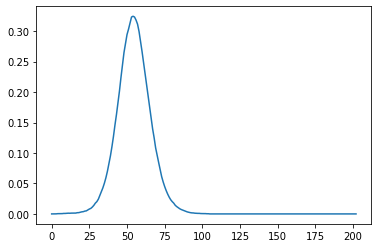

In [7]:
ill_ratio_no_lockdown.plot()

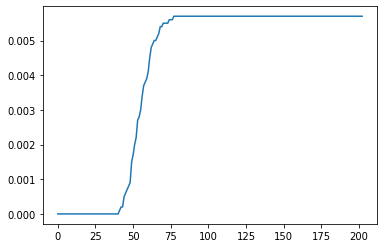

In [8]:
dead_ratio_no_lockdown.plot()

In [9]:
_df = get_ill_dead_ratio_from_spread_model(data_path, 10, 59, 203)
ill_ratio_with_lockdown, dead_ratio_with_lockdown = _df['ill ratio'], _df['dead ratio']

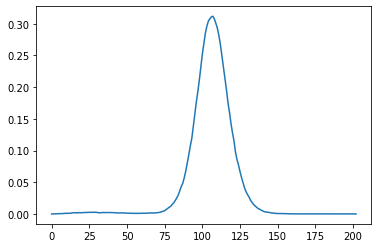

In [10]:
ill_ratio_with_lockdown.plot()

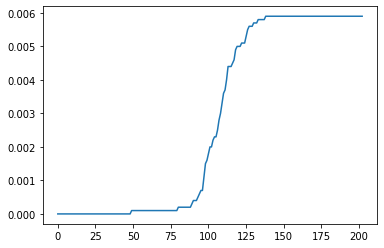

In [11]:
dead_ratio_with_lockdown.plot()

In [13]:
from adapter_covid19.scenarios import BASIC_SCENARIO, BASIC_MODEL_PARAMS, BASIC_NO_LOCKDOWN_SCENARIO

Metrics

In [21]:
scenario = BASIC_NO_LOCKDOWN_SCENARIO

scenario.ill_ratio=ill_ratio_no_lockdown
scenario.dead_ratio=dead_ratio_no_lockdown

In [22]:
scenario.simulation_end_time=20
scenario.spread_model_time_factor=5.

In [23]:
result = simulator.simulate(scenario, show_plots=False, figsize=(5, 15))

100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


In [24]:
econ, states = result

Text(0.5, 1.0, 'dead ratio')

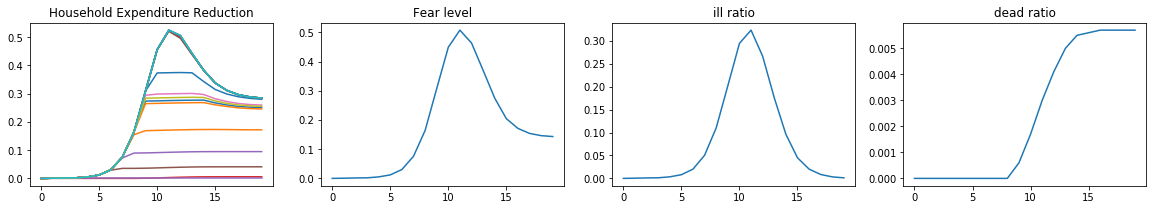

In [25]:
_, axarr = plt.subplots(1, 4, figsize=(20, 3))
pd.DataFrame(
    [state.personal_state.demand_reduction for state in states]
).plot(title="Household Expenditure Reduction", legend=False, ax=axarr[0]),
pd.DataFrame(
    [state.get_fear_factor() for state in states]
).plot(title="Fear level", legend=False, ax=axarr[1])
axarr[2].plot([np.mean(list(state.ill.values())) for state in states])
axarr[2].set_title('ill ratio')
axarr[3].plot([np.mean(list(state.dead.values())) for state in states])
axarr[3].set_title('dead ratio')

In [26]:
from adapter_covid19.metrics import get_quarterly_gdp_decline, get_quarterly_demand_decline

In [27]:
starting_date = pd.Timestamp('2020-03-28').date()

In [28]:
get_quarterly_gdp_decline(starting_date, states)

,GDP decline simulation,GDP decline estimates
2020-03-31,0.998797,0.97
2020-06-30,0.848750,0.75
2020-09-30,NaN,0.82
2020-12-31,NaN,0.90


In [29]:
get_quarterly_demand_decline(starting_date, econ, states)

,Demand decline simulation,Demand decline estimates
2020-03-31,0.998010,NaN
2020-06-30,0.738302,0.6
